In [1]:
import pandas as pd
import sqlite3
import requests
import numpy as np
import folium
import folium.plugins 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
import tabulate

In [2]:
con = sqlite3.connect('Campsite_data_4k-all.db')
query = ''' SELECT A.Latitude, A.Longitude, A.Campsite_Name, Agg_Cluster_Labels, Kmeans_Cluster_Labels FROM Agg A, Kmeans K where A.Latitude = K.Latitude'''
df_RV = pd.read_sql_query(query,con)

In [3]:
df_RV

,Latitude,Longitude,Campsite_Name,Agg_Cluster_Labels,Kmeans_Cluster_Labels
0,55.249428,-127.679933,'KSAN Historical Village Campground,1.0,0.0
1,44.030277,-73.403468,10 Acres Campground and RV Park,8.0,0.0
2,44.276788,-75.997158,1000 Islands Campground,1.0,0.0
3,44.350050,-76.054170,1000 Islands Camping Resort,0.0,7.0
4,43.891877,-76.216943,1000 Islands/Association Island K O A,1.0,0.0
...,...,...,...,...,...
17021,48.847923,-94.849806,Zippel Bay SP,NaN,NaN
17022,35.603549,-79.850677,Zooland Family Campground,NaN,NaN
17023,44.301126,-92.122085,Zumbro Bottoms Horse Campground,NaN,NaN
17024,35.224768,-114.014515,Zuni Village RV Park,NaN,NaN


In [4]:
#df_RV = df_RV.fillna(12)
df_RV = df_RV.dropna()

In [5]:
range_i = list(range(1,int(df_RV['Agg_Cluster_Labels'].max()+2)))
df_clusters = []
for cluster in range_i:
    df_clusters.append(df_RV[df_RV['Agg_Cluster_Labels'] == cluster-1])

In [6]:
df_clusters[0]

,Latitude,Longitude,Campsite_Name,Agg_Cluster_Labels,Kmeans_Cluster_Labels
3,44.350050,-76.054170,1000 Islands Camping Resort,0.0,7.0
17,44.068518,-102.449284,24 Express Campground,0.0,0.0
26,37.819286,-83.723770,4 Guys RV Park at the Gorge,0.0,7.0
30,41.063630,-90.968287,4th Pumping Station Campground (County),0.0,0.0
41,49.145339,-112.083431,8 Flags RV Park,0.0,0.0
...,...,...,...,...,...
15502,37.488670,-89.346552,Trail of Tears State Forest (Tents only),0.0,7.0
15540,38.970887,-105.344306,Travel Port Campground,0.0,7.0
15548,31.751306,-98.921703,Travelers N Park and Campground,0.0,4.0
16673,46.219760,-119.783936,Wine Country RV Park,0.0,10.0


In [7]:
cluster_stats = []
for cluster in df_clusters:
    temp = {}
    temp['Cluster'] = str(int(cluster['Agg_Cluster_Labels'].mean()))
    for i in range_i:
        temp[str(i-1)] = cluster[cluster['Kmeans_Cluster_Labels'] == i-1]['Kmeans_Cluster_Labels'].count()
    cluster_stats.append(temp)

In [8]:
df_cluster_stats = pd.DataFrame(cluster_stats).set_index('Cluster')
df_cluster_stats

,0,1,2,3,4,5,6,7,8,9,10,11
Cluster,,,,,,,,,,,,
0,331,52,66,83,52,1,6,381,27,45,34,7
1,1937,26,11,119,312,0,16,282,30,4,60,8
2,62,2,0,30,8,0,1,21,1,0,205,0
3,41,17,5,2,2,0,1,39,4,5,2,50
4,78,1,0,38,8,0,131,51,3,1,0,0
5,13,1,2,3,0,0,0,1,178,0,4,0
6,27,0,3,271,0,46,0,1,0,0,0,1
7,3,266,0,96,1,0,0,177,2,0,2,0
8,570,2,1,25,2263,0,1,45,4,0,22,0


We would ideally like to see al lthe values run down the diagonal so that the relative groups can have the same labels. Currently the numbers of the groups between the two tests don't match

In [9]:
relabel_groups_list=[]
for i in df_cluster_stats.columns:
    relabel_groups_list.append(int(df_cluster_stats[df_cluster_stats[i].max() == df_cluster_stats[i]].reset_index()['Cluster'].values))

In [10]:
relabel_groups_list[7]=9
relabel_groups_list[9]=10
relabel_groups_list

[1, 7, 0, 6, 8, 11, 4, 9, 5, 10, 2, 3]

In [11]:
df_RV['new_Kmeans_labels'] = df_RV['Kmeans_Cluster_Labels'].map(lambda x:relabel_groups_list[int(x)])

/home/theia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df_RV

,Latitude,Longitude,Campsite_Name,Agg_Cluster_Labels,Kmeans_Cluster_Labels,new_Kmeans_labels
0,55.249428,-127.679933,'KSAN Historical Village Campground,1.0,0.0,1
1,44.030277,-73.403468,10 Acres Campground and RV Park,8.0,0.0,1
2,44.276788,-75.997158,1000 Islands Campground,1.0,0.0,1
3,44.350050,-76.054170,1000 Islands Camping Resort,0.0,7.0,9
4,43.891877,-76.216943,1000 Islands/Association Island K O A,1.0,0.0,1
...,...,...,...,...,...,...
16443,39.200483,-107.231685,White River NF - Redstone Campground,8.0,10.0,2
16673,46.219760,-119.783936,Wine Country RV Park,0.0,10.0,2
16674,46.219760,-119.783936,Wine Country RV Park,0.0,10.0,2
16714,43.311713,-94.704401,Wolden County Recreation Area and Campground,1.0,0.0,1


In [13]:
df_RV.groupby('Agg_Cluster_Labels').count().sum()[0]

9111

In [14]:
range_i = list(range(1,int(df_RV['Agg_Cluster_Labels'].max()+2)))
df_clusters = []
for cluster in range_i:
    df_clusters.append(df_RV[df_RV['Agg_Cluster_Labels'] == cluster-1])
cluster_stats = []

for cluster in df_clusters:
    temp = {}
    temp['Cluster'] = str(int(cluster['Agg_Cluster_Labels'].mean()))
    for i in range_i:
        temp[str(i-1)] = int(cluster[cluster['new_Kmeans_labels'] == i-1]['new_Kmeans_labels'].count())
    temp['Total'] = df_RV.groupby('Agg_Cluster_Labels').count().loc[int(cluster['Agg_Cluster_Labels'].mean())][0]
    cluster_stats.append(temp)
    
temp={}
temp['Cluster']='Total'
temp['Total'] = df_RV.groupby('Agg_Cluster_Labels').count().sum()[0]
for row in df_RV.groupby('new_Kmeans_labels').count().iterrows():
    temp[str(row[0])]=row[1][1]
cluster_stats.append(temp)

df_cluster_stats = pd.DataFrame(cluster_stats).set_index('Cluster')
df_cluster_stats

,0,1,2,3,4,5,6,7,8,9,10,11,Total
Cluster,,,,,,,,,,,,,
0,66,331,34,7,6,27,83,52,52,381,45,1,1085
1,11,1937,60,8,16,30,119,26,312,282,4,0,2805
2,0,62,205,0,1,1,30,2,8,21,0,0,330
3,5,41,2,50,1,4,2,17,2,39,5,0,168
4,0,78,0,0,131,3,38,1,8,51,1,0,311
5,2,13,4,0,0,178,3,1,0,1,0,0,202
6,3,27,0,1,0,0,271,0,0,1,0,46,349
7,0,3,2,0,0,2,96,266,1,177,0,0,547
8,1,570,22,0,1,4,25,2,2263,45,0,0,2933


In [92]:
df_cluster_stats.iloc[-1][5]

282

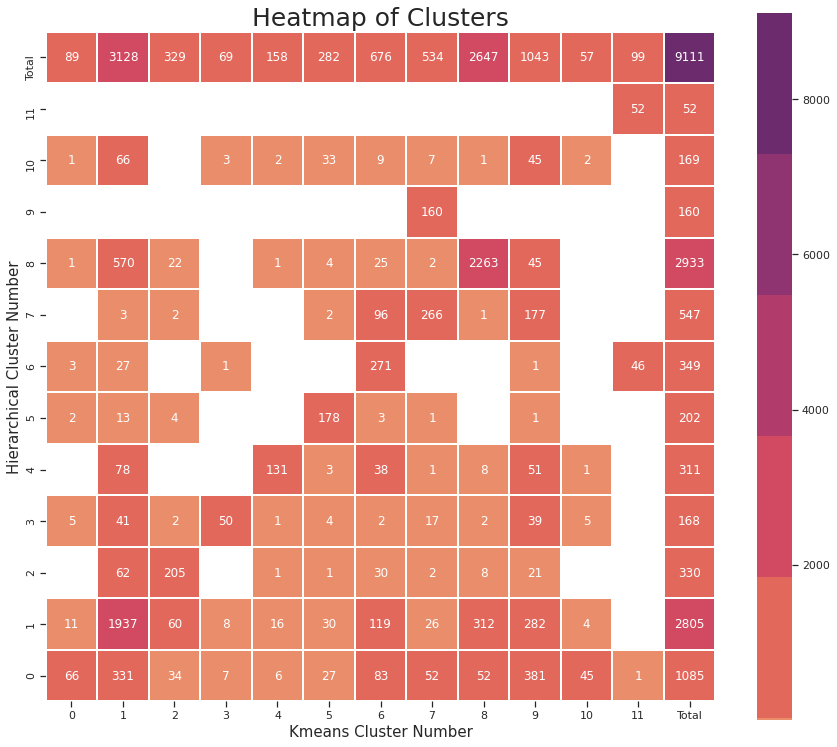

In [154]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13)), plt.axes()
cmap = sns.color_palette("flare")#sns.color_palette("light:#5A9", as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_cluster_stats[df_cluster_stats.columns.tolist()].replace({0:np.nan}),
            annot=True,linewidths=1,
            square=True,
            center=3650,
            fmt='.0f',
            cmap = cmap).invert_yaxis() #400 635
plt.title('Heatmap of Clusters', fontsize = 25) # title with fontsize 20
plt.xlabel('Kmeans Cluster Number', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Hierarchical Cluster Number', fontsize = 15) # y-axis label with fontsize 15
plt.savefig('Agg_Kmeans_corr.png',dpi=500)
plt.show()

The shift from the agreed upon group or better the agreement with the total number of places in that group

In [136]:
def return_totalOr(cluster):
    score = 0
    for row in df_RV.iterrows():
        #if score < 1:
            #print(row[1][5])
        if row[1][3]==i or row[1][5]==i:
            score = score +1
    return score

agreement_scores =[]
for i in list(map(lambda x:x-1,range(1,int(df_RV['Kmeans_Cluster_Labels'].max())+2))):
    temp= {}
    temp['Name'] = 'Cluster {}'.format(i)
    temp['Agreed'] = df_cluster_stats.iloc[i][i]
    temp['Total Hierarchical'] = df_cluster_stats.iloc[i][-1]
    temp['Total Kmeans'] = df_cluster_stats.iloc[-1][i]
    temp['Agreed Score (Hier.)'] = int(temp['Agreed']/temp['Total Hierarchical']*1000)/10
    temp['Agreed Score (Kmeans)'] = int(temp['Agreed']/temp['Total Kmeans']*1000)/10
    temp['Total in either model'] = return_totalOr(i)
    temp['Total Score (Hier.)'] = int(temp['Total Hierarchical']/temp['Total in either model']*1000)/10
    temp['Total Score (Kmeans)'] = int(temp['Total Kmeans']/temp['Total in either model']*1000)/10
    temp['Dominant'] = (lambda x: "Kmeans" if x>temp['Agreed Score (Hier.)'] else 'Hierarchical')(temp['Agreed Score (Kmeans)'])
    agreement_scores.append(temp)

df_scores = pd.DataFrame(agreement_scores).set_index('Name')
print(df_scores.to_markdown())
df_scores

| Name       |   Agreed |   Total Hierarchical |   Total Kmeans |   Agreed Score (Hier.) |   Agreed Score (Kmeans) |   Total in either model |   Total Score (Hier.) |   Total Score (Kmeans) | Dominant     |
|:-----------|---------:|---------------------:|---------------:|-----------------------:|------------------------:|------------------------:|----------------------:|-----------------------:|:-------------|
| Cluster 0  |       66 |                 1085 |             89 |                    6   |                    74.1 |                    1108 |                  97.9 |                    8   | Kmeans       |
| Cluster 1  |     1937 |                 2805 |           3128 |                   69   |                    61.9 |                    3996 |                  70.1 |                   78.2 | Hierarchical |
| Cluster 2  |      205 |                  330 |            329 |                   62.1 |                    62.3 |                     454 |                  72.6 |      

,Agreed,Total Hierarchical,Total Kmeans,Agreed Score (Hier.),Agreed Score (Kmeans),Total in either model,Total Score (Hier.),Total Score (Kmeans),Dominant
Name,,,,,,,,,
Cluster 0,66,1085,89,6.0,74.1,1108,97.9,8.0,Kmeans
Cluster 1,1937,2805,3128,69.0,61.9,3996,70.1,78.2,Hierarchical
Cluster 2,205,330,329,62.1,62.3,454,72.6,72.4,Kmeans
Cluster 3,50,168,69,29.7,72.4,187,89.8,36.8,Kmeans
Cluster 4,131,311,158,42.1,82.9,338,92.0,46.7,Kmeans
Cluster 5,178,202,282,88.1,63.1,306,66.0,92.1,Hierarchical
Cluster 6,271,349,676,77.6,40.0,754,46.2,89.6,Hierarchical
Cluster 7,266,547,534,48.6,49.8,815,67.1,65.5,Kmeans
Cluster 8,2263,2933,2647,77.1,85.4,3317,88.4,79.8,Kmeans


In [137]:
df_scores.describe()

,Agreed,Total Hierarchical,Total Kmeans,Agreed Score (Hier.),Agreed Score (Kmeans),Total in either model,Total Score (Hier.),Total Score (Kmeans)
count,12.000000,12.000000,12.00000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,451.750000,759.250000,759.25000,50.116667,53.991667,1066.750000,69.275000,65.091667
std,778.625377,1021.706961,1041.93475,34.717950,27.732471,1269.631094,23.615524,29.273955
min,0.000000,52.000000,57.00000,0.000000,0.000000,99.000000,13.300000,8.000000
25%,51.500000,168.750000,96.50000,23.775000,47.350000,285.500000,62.625000,44.225000
50%,154.500000,320.500000,305.50000,55.350000,62.100000,604.000000,71.350000,75.300000
75%,267.250000,681.500000,767.75000,77.225000,72.825000,1131.750000,88.750000,87.350000
max,2263.000000,2933.000000,3128.00000,100.000000,85.400000,3996.000000,97.900000,100.000000


In [138]:
df_scores['Agreed'].sum()

5421

In [28]:
print(df_cluster_stats.to_markdown())

| Cluster   |   0 |    1 |   2 |   3 |   4 |   5 |   6 |   7 |    8 |    9 |   10 |   11 |   Total |
|:----------|----:|-----:|----:|----:|----:|----:|----:|----:|-----:|-----:|-----:|-----:|--------:|
| 0         |  66 |  331 |  34 |   7 |   6 |  27 |  83 |  52 |   52 |  381 |   45 |    1 |    1085 |
| 1         |  11 | 1937 |  60 |   8 |  16 |  30 | 119 |  26 |  312 |  282 |    4 |    0 |    2805 |
| 2         |   0 |   62 | 205 |   0 |   1 |   1 |  30 |   2 |    8 |   21 |    0 |    0 |     330 |
| 3         |   5 |   41 |   2 |  50 |   1 |   4 |   2 |  17 |    2 |   39 |    5 |    0 |     168 |
| 4         |   0 |   78 |   0 |   0 | 131 |   3 |  38 |   1 |    8 |   51 |    1 |    0 |     311 |
| 5         |   2 |   13 |   4 |   0 |   0 | 178 |   3 |   1 |    0 |    1 |    0 |    0 |     202 |
| 6         |   3 |   27 |   0 |   1 |   0 |   0 | 271 |   0 |    0 |    1 |    0 |   46 |     349 |
| 7         |   0 |    3 |   2 |   0 |   0 |   2 |  96 | 266 |    1 |  177 |    0 |    0 | 

In [80]:
con = sqlite3.connect('Campsite_data_4k-all.db')
query = ''' SELECT * FROM Agg_top_ten'''
df_Agg_top_ten = pd.read_sql_query(query,con).drop('index',axis=1).set_index('name')
query = ''' SELECT * FROM Kmeans_top_ten   '''
df_Kmeans_top_ten = pd.read_sql_query(query,con).drop('index',axis=1).set_index('name')
con.close()

In [81]:
df_Kmeans_top_ten

,1,2,3,4,5,6,7,8,9,10
name,,,,,,,,,,
Cluster 0,American Restaurant,Hotel,Restaurant,Convenience Store,Bar,Harbor / Marina,Scenic Lookout,Park,Seafood Restaurant,Resort
Cluster 1,Campground,Lake,State / Provincial Park,Home Service,Scenic Lookout,Beach,Construction & Landscaping,Trail,American Restaurant,Convenience Store
Cluster 2,Park,Campground,State / Provincial Park,Lake,Convenience Store,Home Service,Hotel,Golf Course,River,Trail
Cluster 3,Lake,Campground,Harbor / Marina,State / Provincial Park,American Restaurant,Trail,Construction & Landscaping,Scenic Lookout,Convenience Store,Golf Course
Cluster 4,Fast Food Restaurant,Gas Station,Sandwich Place,Pizza Place,Discount Store,Convenience Store,Grocery Store,Coffee Shop,American Restaurant,Mexican Restaurant
Cluster 5,Lake,Campground,Harbor / Marina,State / Provincial Park,Burger Joint,Beach,Resort,Tourist Information Center,Rest Area,Park
Cluster 6,Beach,Campground,Harbor / Marina,State / Provincial Park,Resort,Scenic Lookout,Trail,National Park,Seafood Restaurant,Park
Cluster 7,Campground,Trail,American Restaurant,Park,Scenic Lookout,Convenience Store,Construction & Landscaping,Home Service,State / Provincial Park,Farm
Cluster 8,Trail,Campground,Scenic Lookout,State / Provincial Park,Mountain,National Park,Park,Tourist Information Center,Lake,American Restaurant


In [82]:
rearrange_list = []
for i in list(map(lambda x:x-1,range(1,np.array(relabel_groups_list).max()+2))):
    temp =df_Kmeans_top_ten.iloc[relabel_groups_list[i]].to_dict()
    temp['name'] = 'Cluster {}'.format(i)
    rearrange_list.append(temp)
df_Kmeans_top_ten = pd.DataFrame(rearrange_list).set_index('name')
df_Kmeans_top_ten

,1,2,3,4,5,6,7,8,9,10
name,,,,,,,,,,
Cluster 0,Campground,Lake,State / Provincial Park,Home Service,Scenic Lookout,Beach,Construction & Landscaping,Trail,American Restaurant,Convenience Store
Cluster 1,Campground,Trail,American Restaurant,Park,Scenic Lookout,Convenience Store,Construction & Landscaping,Home Service,State / Provincial Park,Farm
Cluster 2,American Restaurant,Hotel,Restaurant,Convenience Store,Bar,Harbor / Marina,Scenic Lookout,Park,Seafood Restaurant,Resort
Cluster 3,Beach,Campground,Harbor / Marina,State / Provincial Park,Resort,Scenic Lookout,Trail,National Park,Seafood Restaurant,Park
Cluster 4,Trail,Campground,Scenic Lookout,State / Provincial Park,Mountain,National Park,Park,Tourist Information Center,Lake,American Restaurant
Cluster 5,State / Provincial Park,American Restaurant,Post Office,Resort,Scenic Lookout,Bakery,Campground,River,Intersection,Music Venue
Cluster 6,Fast Food Restaurant,Gas Station,Sandwich Place,Pizza Place,Discount Store,Convenience Store,Grocery Store,Coffee Shop,American Restaurant,Mexican Restaurant
Cluster 7,Golf Course,Campground,Construction & Landscaping,Lake,State / Provincial Park,Insurance Office,RV Park,Fast Food Restaurant,Coffee Shop,American Restaurant
Cluster 8,Lake,Campground,Harbor / Marina,State / Provincial Park,Burger Joint,Beach,Resort,Tourist Information Center,Rest Area,Park


In [83]:
df_Agg_top_ten

,1,2,3,4,5,6,7,8,9,10
name,,,,,,,,,,
Cluster 0,Campground,Park,Golf Course,River,Mountain,Trail,Farm,Lake,Business Service,Post Office
Cluster 1,American Restaurant,Campground,Hotel,Convenience Store,Restaurant,Harbor / Marina,Bar,Grocery Store,Resort,Home Service
Cluster 2,Construction & Landscaping,Campground,Lake,Auto Workshop,Garden Center,Home Service,Restaurant,Other Repair Shop,Grocery Store,Business Service
Cluster 3,State / Provincial Park,Campground,Park,Trail,Golf Course,American Restaurant,Home Service,Construction & Landscaping,Bookstore,Restaurant
Cluster 4,Beach,Campground,Boat or Ferry,Lake,National Park,Harbor / Marina,Trail,State / Provincial Park,Scenic Lookout,Resort
Cluster 5,Trail,Campground,State / Provincial Park,Mountain,National Park,Tourist Information Center,Park,Food,Lake,Scenic Lookout
Cluster 6,Lake,Campground,Harbor / Marina,State / Provincial Park,American Restaurant,Scenic Lookout,Golf Course,Convenience Store,Park,Hotel
Cluster 7,Campground,Lake,Home Service,Trail,Convenience Store,Beach,Construction & Landscaping,State / Provincial Park,Hotel,Forest
Cluster 8,Fast Food Restaurant,Gas Station,Pizza Place,Sandwich Place,Discount Store,Coffee Shop,Convenience Store,Grocery Store,American Restaurant,Mexican Restaurant


In [163]:
compare_venues_list =[]
agg_venues=[]
for i in list(map(lambda x:x-1,range(1,int(df_RV['Kmeans_Cluster_Labels'].max())+2))):
    temp =df_Kmeans_top_ten.reset_index().iloc[i].to_dict()
    temp['name'] = 'Kmeans: {}'.format(temp['name'])
    compare_venues_list.append(temp)
    temp =df_Agg_top_ten.reset_index().iloc[i].to_dict()
    temp['name'] = 'Hierarchical: {}'.format(temp['name'])
    compare_venues_list.append(temp)
    agg_venues.append(temp)

df_compare_top_5 = pd.DataFrame(compare_venues_list).set_index('name').iloc[:,:5]

In [88]:
df_compare_top_5

,1,2,3,4,5
name,,,,,
Kmeans: Cluster 0,Campground,Lake,State / Provincial Park,Home Service,Scenic Lookout
Hierarchical: Cluster 0,Campground,Park,Golf Course,River,Mountain
Kmeans: Cluster 1,Campground,Trail,American Restaurant,Park,Scenic Lookout
Hierarchical: Cluster 1,American Restaurant,Campground,Hotel,Convenience Store,Restaurant
Kmeans: Cluster 2,American Restaurant,Hotel,Restaurant,Convenience Store,Bar
Hierarchical: Cluster 2,Construction & Landscaping,Campground,Lake,Auto Workshop,Garden Center
Kmeans: Cluster 3,Beach,Campground,Harbor / Marina,State / Provincial Park,Resort
Hierarchical: Cluster 3,State / Provincial Park,Campground,Park,Trail,Golf Course
Kmeans: Cluster 4,Trail,Campground,Scenic Lookout,State / Provincial Park,Mountain


In [158]:
df_compare_top_5

,1,2,3,4,5
name,,,,,
Kmeans: Cluster 0,Campground,Lake,State / Provincial Park,Home Service,Scenic Lookout
Hierarchical: Cluster 0,Campground,Park,Golf Course,River,Mountain
Kmeans: Cluster 1,Campground,Trail,American Restaurant,Park,Scenic Lookout
Hierarchical: Cluster 1,American Restaurant,Campground,Hotel,Convenience Store,Restaurant
Kmeans: Cluster 2,American Restaurant,Hotel,Restaurant,Convenience Store,Bar
Hierarchical: Cluster 2,Construction & Landscaping,Campground,Lake,Auto Workshop,Garden Center
Kmeans: Cluster 3,Beach,Campground,Harbor / Marina,State / Provincial Park,Resort
Hierarchical: Cluster 3,State / Provincial Park,Campground,Park,Trail,Golf Course
Kmeans: Cluster 4,Trail,Campground,Scenic Lookout,State / Provincial Park,Mountain


In [165]:
df_temp = df_compare_top_5.reset_index()
print(pd.DataFrame(agg_venues).set_index('name').iloc[:,:5].to_markdown())

| name                     | 1                          | 2           | 3                       | 4                       | 5                   |
|:-------------------------|:---------------------------|:------------|:------------------------|:------------------------|:--------------------|
| Hierarchical: Cluster 0  | Campground                 | Park        | Golf Course             | River                   | Mountain            |
| Hierarchical: Cluster 1  | American Restaurant        | Campground  | Hotel                   | Convenience Store       | Restaurant          |
| Hierarchical: Cluster 2  | Construction & Landscaping | Campground  | Lake                    | Auto Workshop           | Garden Center       |
| Hierarchical: Cluster 3  | State / Provincial Park    | Campground  | Park                    | Trail                   | Golf Course         |
| Hierarchical: Cluster 4  | Beach                      | Campground  | Boat or Ferry           | Lake                    | 

In [152]:
def compareClusters(x,y):
    if x==y:
        return x
    else:
        return np.nan
    
agreed_list=[]
    
for row in df_RV.iterrows():
    temp = row[1].to_dict()
    temp['Agreed'] = compareClusters(temp['new_Kmeans_labels'],temp['Agg_Cluster_Labels'])
    agreed_list.append(temp)
    
df_agreed = pd.DataFrame(agreed_list).dropna().reset_index().drop('index',1)

In [153]:
# create map of RV parks using latitude and longitude values
latitude = df_agreed['Latitude'].mean()
longitude = df_agreed['Longitude'].mean()
map_national_RV_parks_clusters = {}
for cluster in df_agreed.groupby('Agg_Cluster_Labels').count().reset_index()['Agg_Cluster_Labels'].tolist():
    
    map_national_RV_parks_clusters[cluster] = folium.Map(location=[latitude, longitude], zoom_start=4)

    # add markers to map
    marker_cluster_clusters = {}
    marker_cluster_clusters[cluster] = folium.plugins.MarkerCluster().add_to(map_national_RV_parks_clusters[cluster])
    for lat, lng, name in zip(df_agreed[df_agreed['Agg_Cluster_Labels']==cluster]['Latitude'], 
                              df_agreed[df_agreed['Agg_Cluster_Labels']==cluster]['Longitude'], 
                              df_agreed.reset_index()[df_agreed['Agg_Cluster_Labels']==cluster]['Campsite_Name']):
        label = "<a  target='_blank' href='https://www.google.com/search?q={}'>{}</a>".format(name.replace(' ','%20'),name)
        #label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(marker_cluster_clusters[cluster])  

    map_national_RV_parks_clusters[cluster].save('Joined/Cluster {} from analysis.html'.format(cluster))